In [16]:
!git clone https://github.com/YoongiKim/CIFAR-10-images

fatal: destination path 'CIFAR-10-images' already exists and is not an empty directory.


In [17]:
# import io
# import requests
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)

In [18]:
!ls

CIFAR-10-images  model_cifar.pt  sample_data


In [19]:
!pwd

/content


In [20]:
# !cd CIFAR-10-images/

In [21]:
!ls

CIFAR-10-images  model_cifar.pt  sample_data


In [22]:
import torch
import numpy as np
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import cv2
from skimage import io, transform
from PIL import Image
from sklearn.model_selection import train_test_split
import torch.optim as optim


# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

In [23]:
# check if CUDA is available
train_on_gpu = torch.cuda.is_available()

if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')


CUDA is available!  Training on GPU ...


In [24]:
def load_images(train_path,test_path):
  train_classes = os.listdir(train_path)
  test_classes = os.listdir(test_path)

  train_images = []
  test_images = []

  print("Loading Train Images")
  for cls in train_classes:
    print("Reading images of class: ", cls)
    cls_path = os.path.join(train_path, cls)
    for img_id in os.listdir(cls_path):
      img = cv2.imread(os.path.join(cls_path, img_id))
      # img=img/255
      #img=img.astype("float32")
      train_images.append([img, cls])

  print("Loading Test Images")
  for cls in test_classes:
    print("Reading images of class: ", cls)
    cls_path = os.path.join(test_path, cls)
    for img_id in os.listdir(cls_path):
      img = cv2.imread(os.path.join(cls_path, img_id))
      # img= img/255
      #img=img.astype("float32")
      test_images.append([img, cls])
  
  return  train_images,test_images



train_path = '/content/CIFAR-10-images/train'
test_path = '/content/CIFAR-10-images/test'

train_images ,test_images= load_images(train_path,test_path)
train_images, valid_images = train_test_split(train_images, test_size = 0.2)
print(len(train_images), len(test_images), len(valid_images))

Loading Train Images
Reading images of class:  airplane
Reading images of class:  bird
Reading images of class:  ship
Reading images of class:  cat
Reading images of class:  truck
Reading images of class:  deer
Reading images of class:  horse
Reading images of class:  automobile
Reading images of class:  dog
Reading images of class:  frog
Loading Test Images
Reading images of class:  airplane
Reading images of class:  bird
Reading images of class:  ship
Reading images of class:  cat
Reading images of class:  truck
Reading images of class:  deer
Reading images of class:  horse
Reading images of class:  automobile
Reading images of class:  dog
Reading images of class:  frog
40000 10000 10000


In [25]:
train_images[0]

[array([[[236, 234, 224],
         [241, 239, 229],
         [241, 238, 233],
         ...,
         [246, 239, 242],
         [245, 238, 243],
         [243, 236, 241]],
 
        [[236, 234, 224],
         [235, 232, 224],
         [230, 226, 221],
         ...,
         [246, 239, 242],
         [246, 239, 244],
         [245, 238, 243]],
 
        [[214, 208, 201],
         [218, 212, 205],
         [215, 209, 204],
         ...,
         [248, 240, 241],
         [248, 239, 242],
         [247, 238, 241]],
 
        ...,
 
        [[ 77,  46,  73],
         [ 85,  56,  81],
         [ 91,  61,  86],
         ...,
         [164, 146, 177],
         [158, 139, 172],
         [156, 136, 171]],
 
        [[ 84,  51,  78],
         [ 90,  60,  85],
         [ 97,  65,  90],
         ...,
         [158, 141, 175],
         [188, 170, 207],
         [187, 169, 206]],
 
        [[ 89,  56,  83],
         [ 97,  65,  90],
         [101,  69,  94],
         ...,
         [122, 105, 139],
  

In [26]:
os.listdir('/content/CIFAR-10-images/train')

['airplane',
 'bird',
 'ship',
 'cat',
 'truck',
 'deer',
 'horse',
 'automobile',
 'dog',
 'frog']

In [27]:
class CifarDataset(Dataset):
    def __init__(self, images, transform=None):
        '''
        Args : 
            csvfile : train/val/test csvfiles
            audio_dir : directory that contains folders 0 - f
        '''
        self.images = images
        self.transform = transform

    # get one segment (==59049 samples) and its 50-d label
    def __getitem__(self, index):

      if self.transform:
        x = torch.tensor(self.transform(Image.fromarray(self.images[index][0]))).to(torch.float32)
      else:
        x = torch.tensor(Image.fromarray(self.images[index][0])).to(torch.float32)
      y = self.images[index][1]

      sample = {'image': x, 'class': y}

      # if self.transform:
      #   sample = self.transform(sample)


      return sample

        
    
    def __len__(self):
        return len(self.images)


transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)),
])


train_data = CifarDataset(train_images,transform=transform_train)
test_data = CifarDataset(test_images,transform=transform_test)
valid_data = CifarDataset(valid_images,transform=transform_train)

print(len(train_data), len(test_data),len(valid_data))


trainloader = torch.utils.data.DataLoader(
    train_data, batch_size=20, shuffle=True, num_workers=2)
validloader = torch.utils.data.DataLoader(valid_data, batch_size=20,shuffle=True, num_workers=2)
testloader = torch.utils.data.DataLoader(
    test_data, batch_size=20, shuffle=False, num_workers=2)

40000 10000 10000


In [28]:
train_data[0]

{'class': 'dog',
 'image': tensor([[[ 2.3396,  2.3396,  2.3202,  ...,  2.1264,  2.1458, -2.4291],
          [ 2.3784,  2.3784,  2.3590,  ...,  1.7968,  1.7193, -2.4291],
          [ 2.3784,  2.3590,  2.3978,  ...,  1.7581,  1.5255, -2.4291],
          ...,
          [ 1.2153,  0.6338,  0.0716,  ..., -0.6844, -0.8007, -2.4291],
          [ 0.8858, -0.0641,  0.1104,  ..., -0.5487, -0.7038, -2.4291],
          [-2.4291, -2.4291, -2.4291,  ..., -2.4291, -2.4291, -2.4291]],
 
         [[ 2.2821,  2.2821,  2.2821,  ...,  2.1445,  2.1838, -2.4183],
          [ 2.2821,  2.3018,  2.2821,  ...,  1.7511,  1.6724, -2.4183],
          [ 2.2428,  2.2821,  2.2821,  ...,  1.6724,  1.4364, -2.4183],
          ...,
          [ 0.9251,  0.3548, -0.1959,  ..., -1.2382, -1.4152, -2.4183],
          [ 0.5711, -0.3532, -0.1762,  ..., -1.1399, -1.3169, -2.4183],
          [-2.4183, -2.4183, -2.4183,  ..., -2.4183, -2.4183, -2.4183]],
 
         [[ 2.5391,  2.5001,  2.4611,  ...,  2.1489,  2.1489, -2.2214],
  

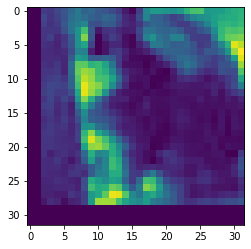

cat


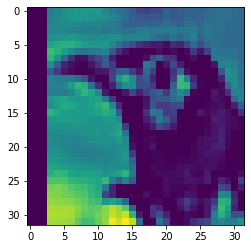

bird


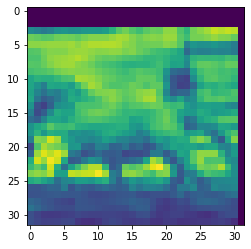

horse


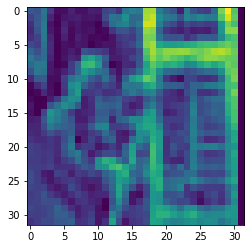

cat


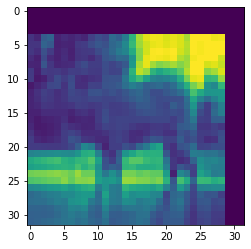

deer


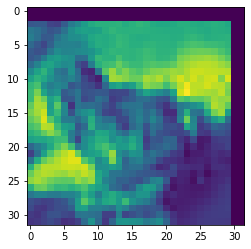

frog


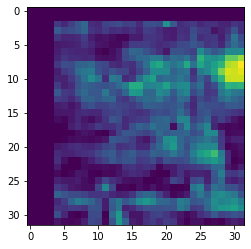

automobile


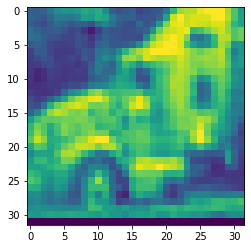

truck


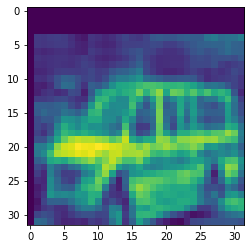

automobile


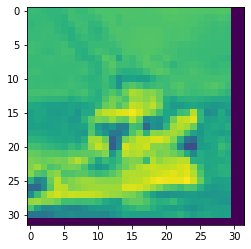

ship


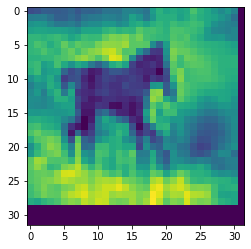

horse


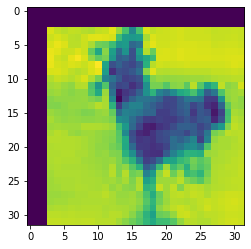

bird


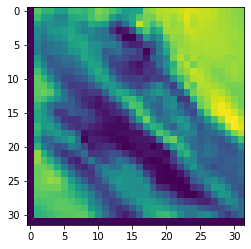

frog


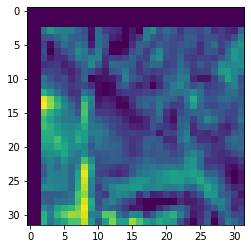

deer


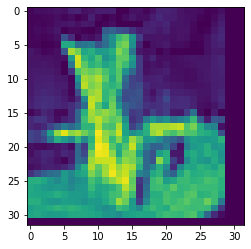

cat


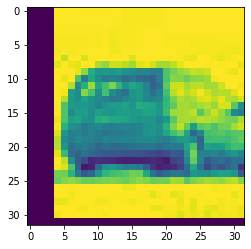

automobile


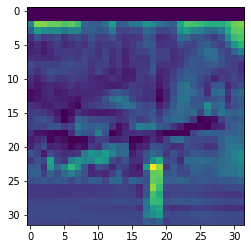

airplane


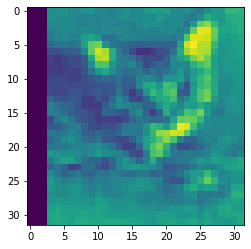

cat


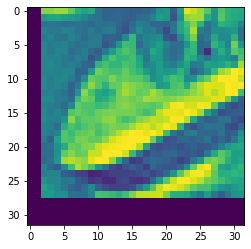

ship


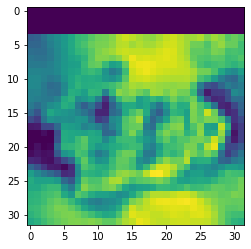

cat


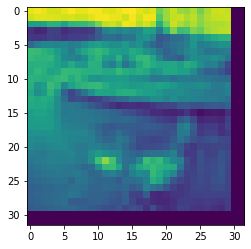

ship


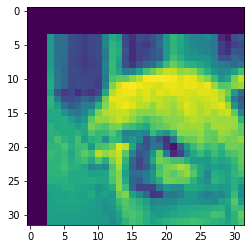

dog


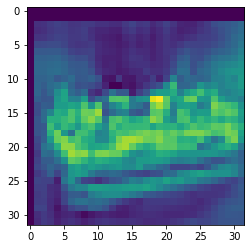

ship


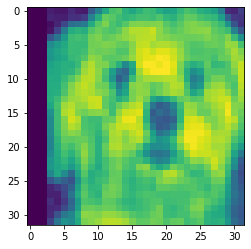

dog


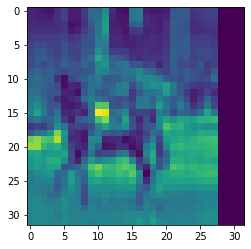

horse


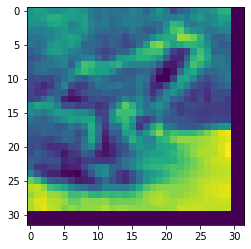

frog


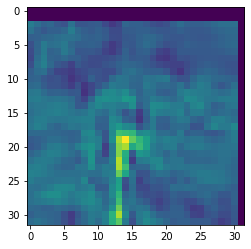

cat


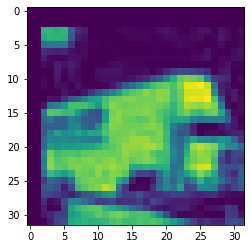

truck


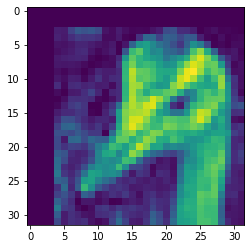

bird


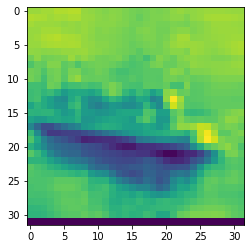

ship


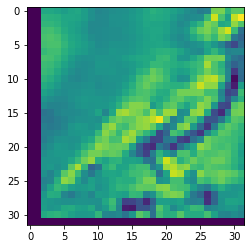

bird


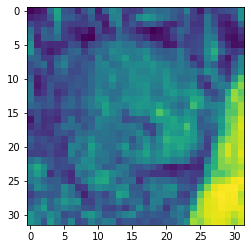

frog


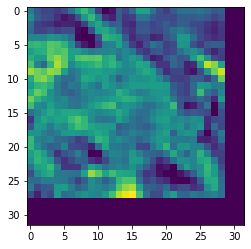

cat


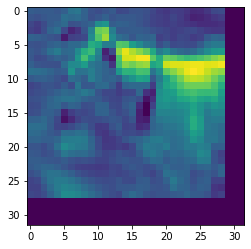

dog


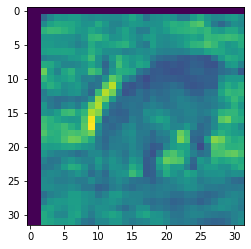

deer


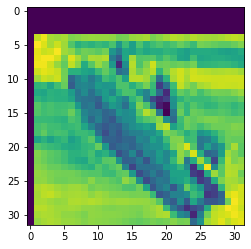

ship


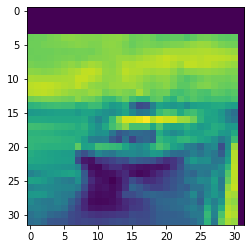

ship


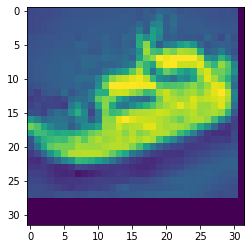

ship


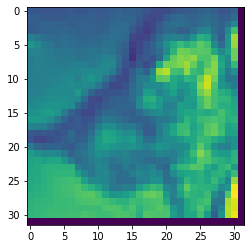

cat


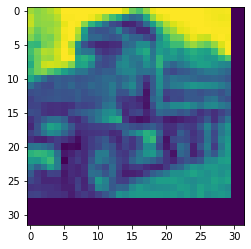

truck


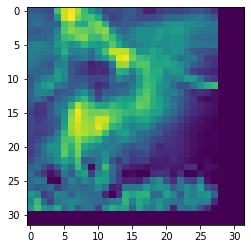

bird


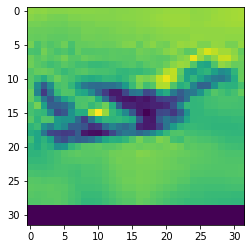

airplane


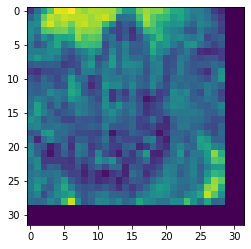

frog


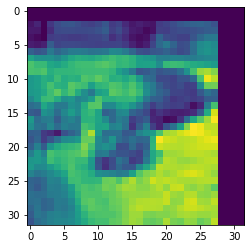

cat


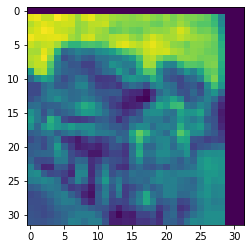

truck


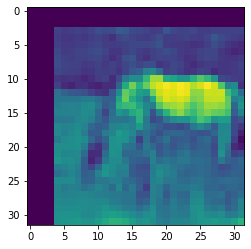

horse


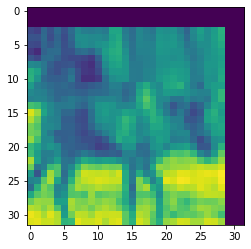

deer


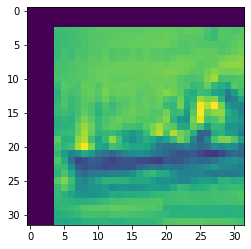

ship


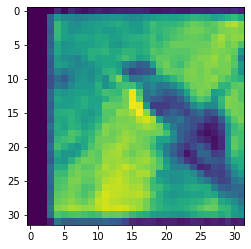

bird


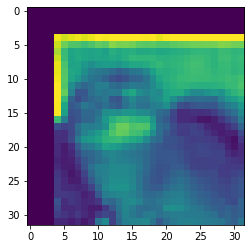

cat


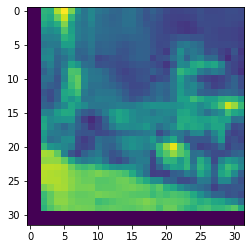

truck


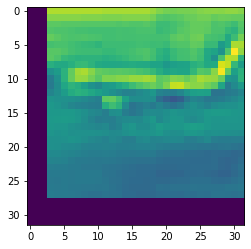

airplane


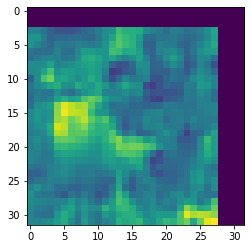

bird


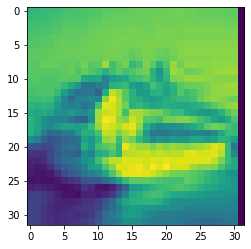

ship


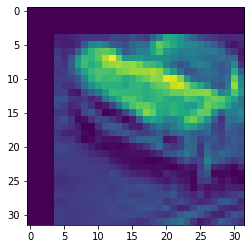

automobile


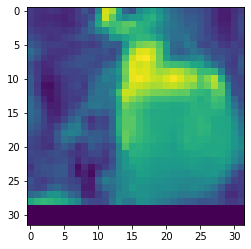

bird


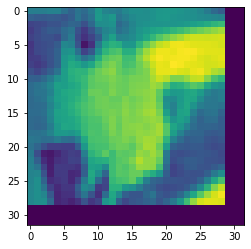

cat


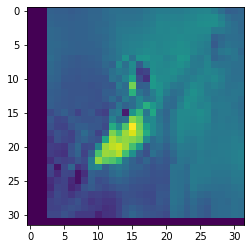

bird


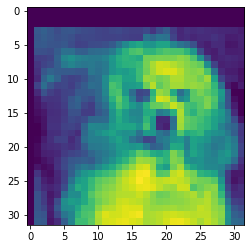

dog


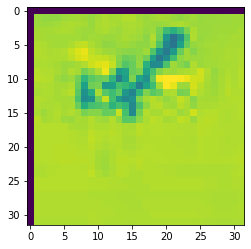

airplane


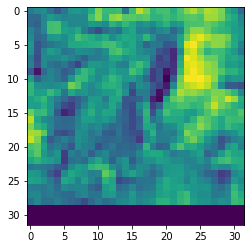

frog


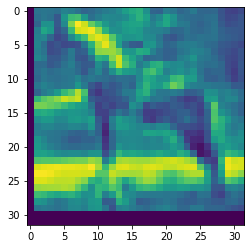

horse


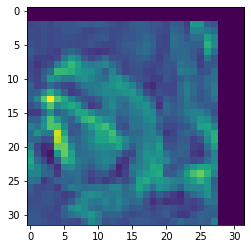

frog


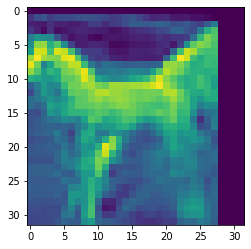

horse


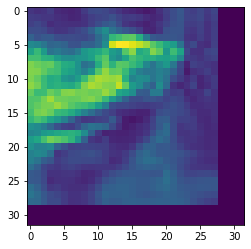

ship


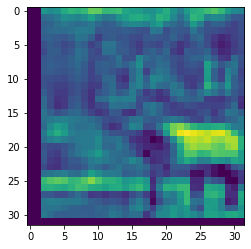

deer


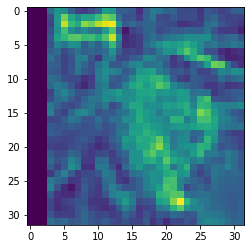

frog


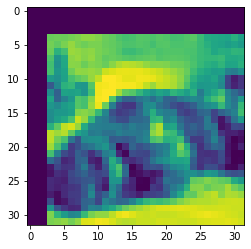

cat


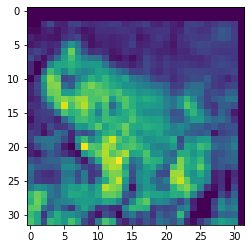

frog


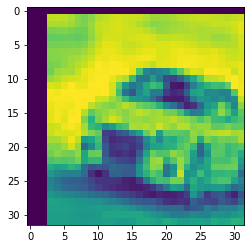

automobile


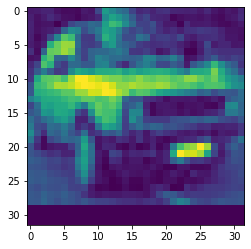

automobile


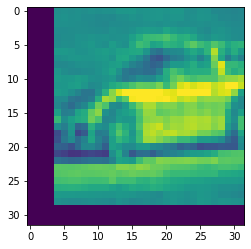

automobile


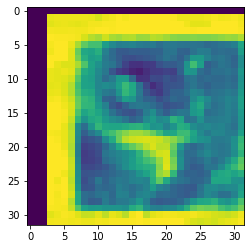

cat


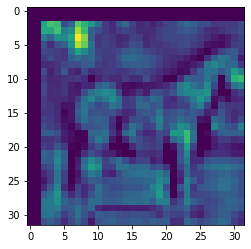

horse


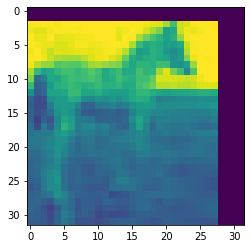

horse


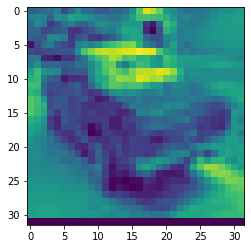

automobile


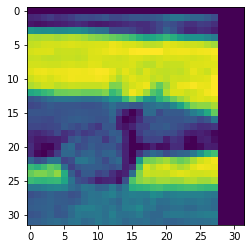

deer


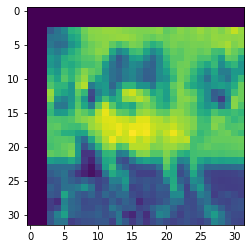

horse


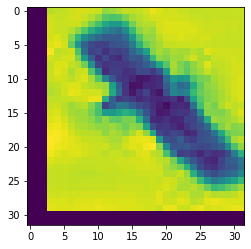

bird


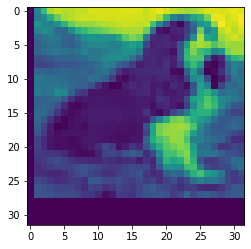

dog


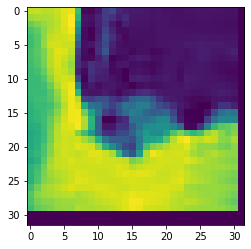

cat


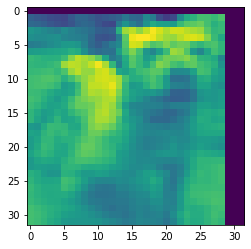

dog


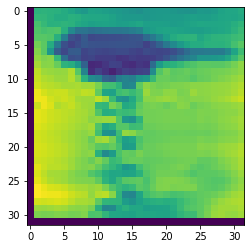

airplane


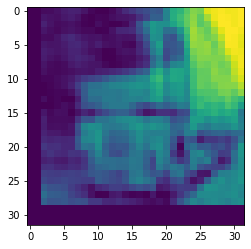

truck


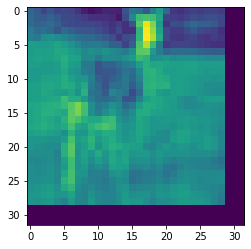

deer


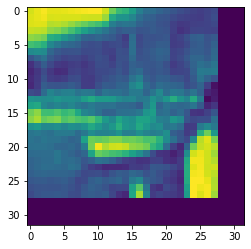

ship


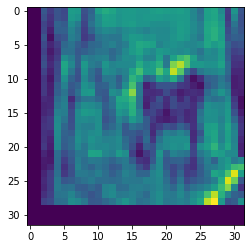

deer


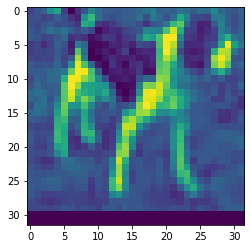

dog


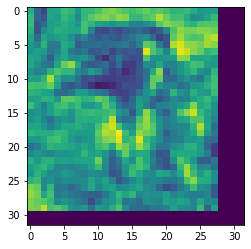

bird


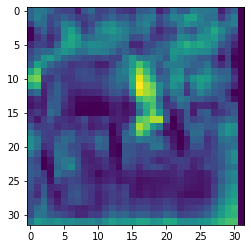

deer


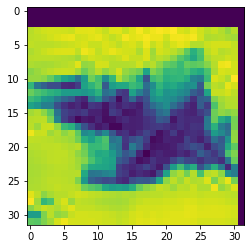

airplane


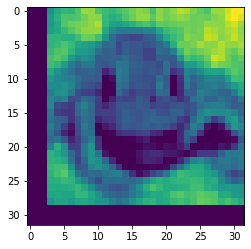

frog


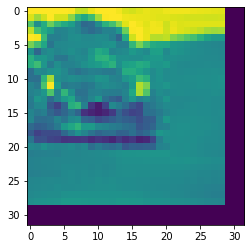

automobile


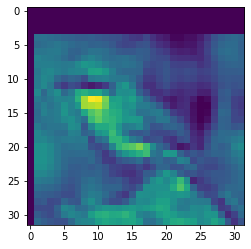

bird


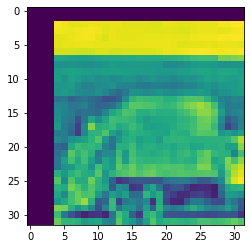

truck


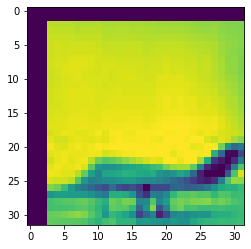

airplane


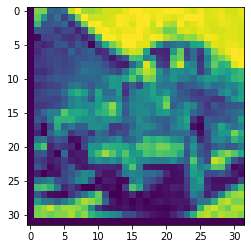

truck


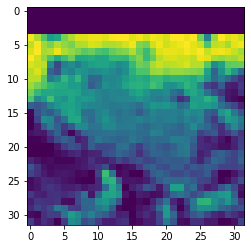

frog


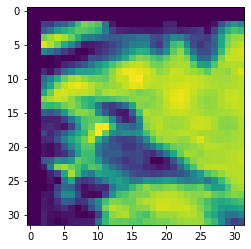

bird


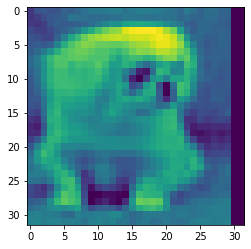

dog


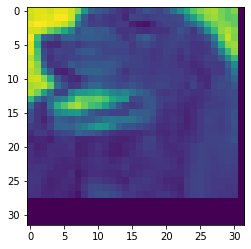

dog


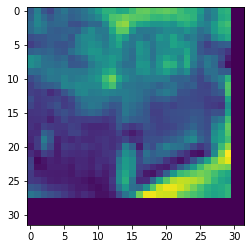

automobile


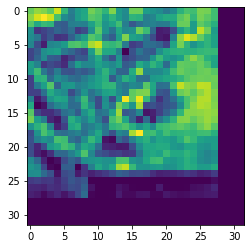

frog


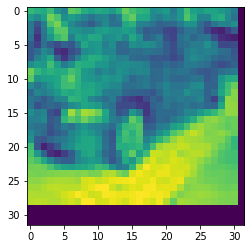

automobile


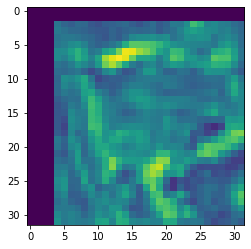

frog


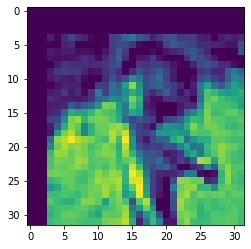

bird


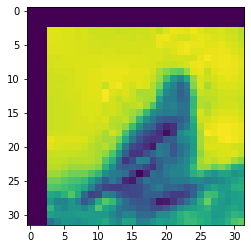

bird


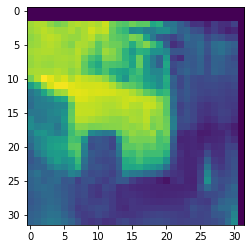

truck


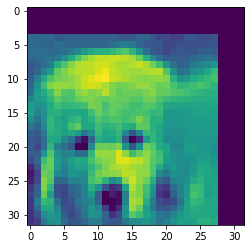

dog


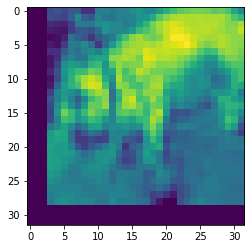

dog


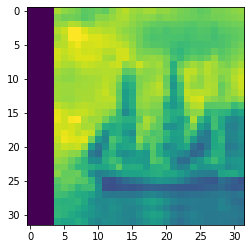

ship


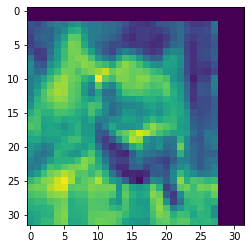

deer


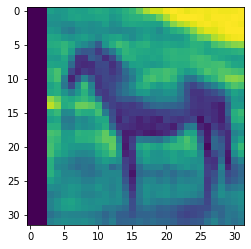

horse


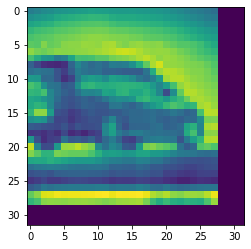

automobile


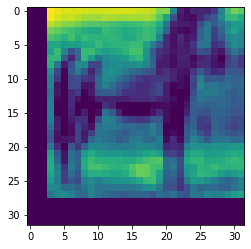

horse


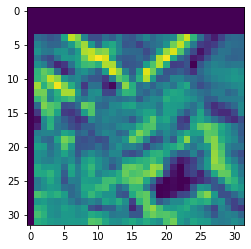

frog


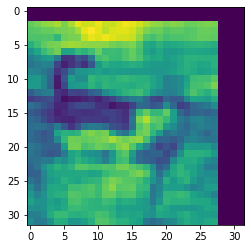

cat


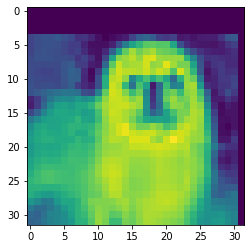

dog


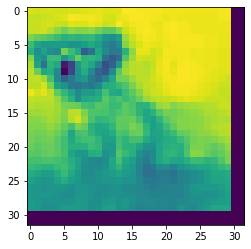

dog


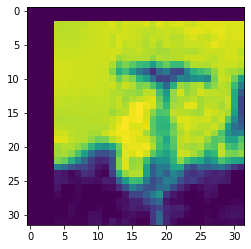

airplane


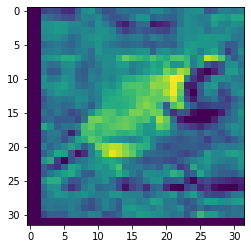

bird


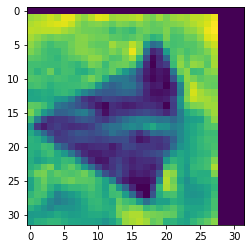

airplane


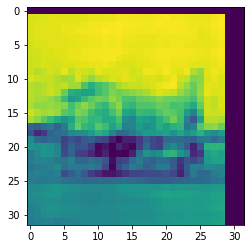

airplane


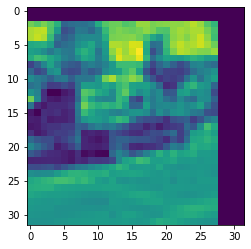

automobile


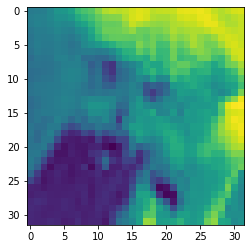

dog


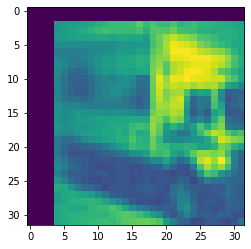

truck


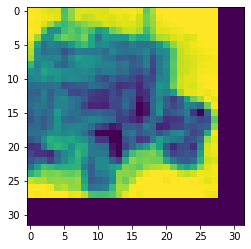

truck


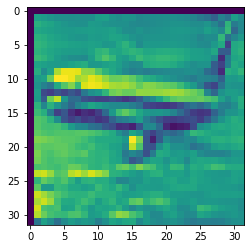

airplane


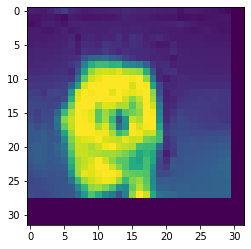

dog


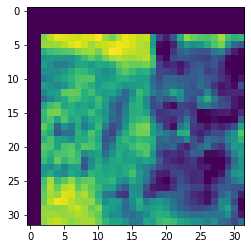

cat


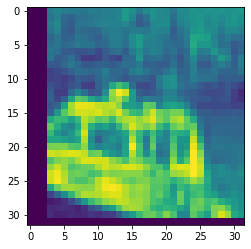

ship


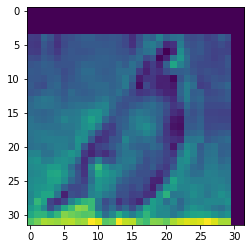

bird


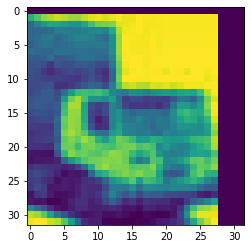

truck


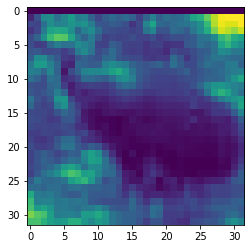

bird


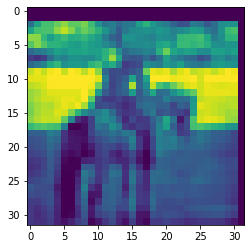

horse


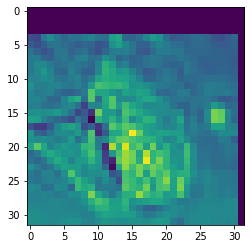

frog


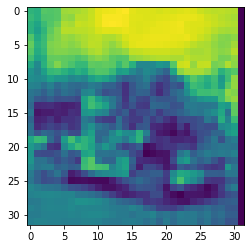

truck


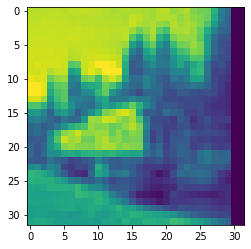

truck


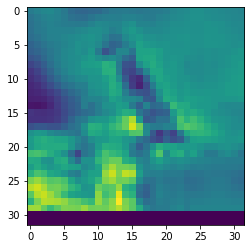

bird


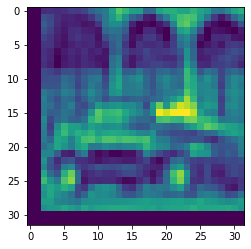

automobile


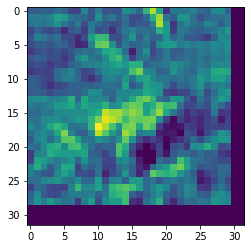

frog


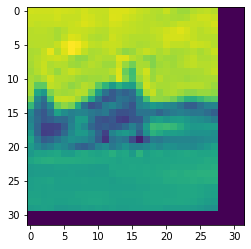

airplane


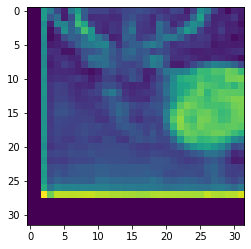

deer


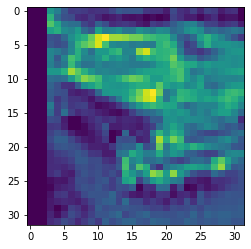

automobile


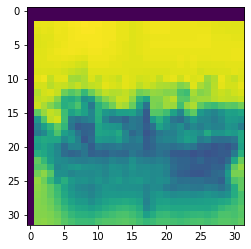

ship


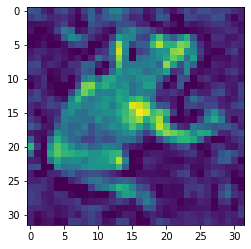

frog


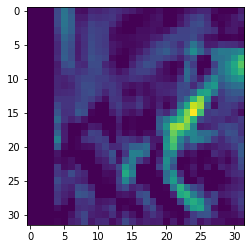

frog


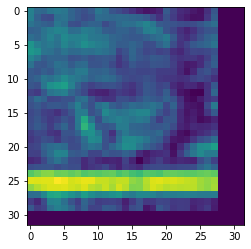

frog


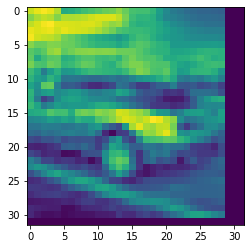

automobile


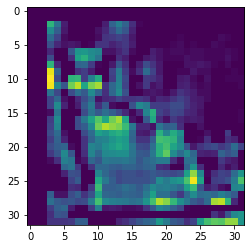

cat


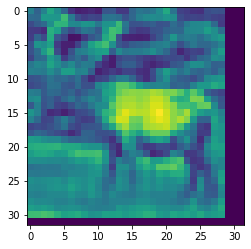

deer


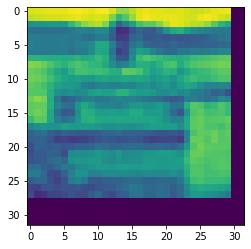

ship


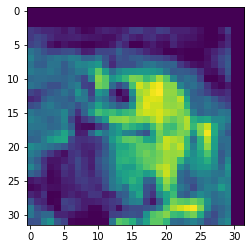

frog


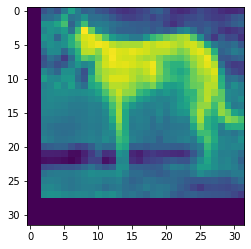

dog


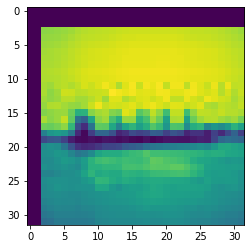

ship


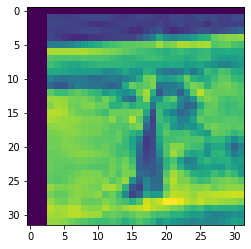

bird


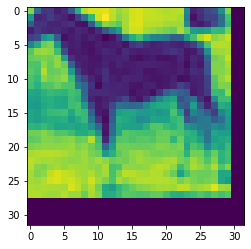

horse


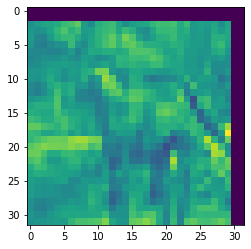

horse


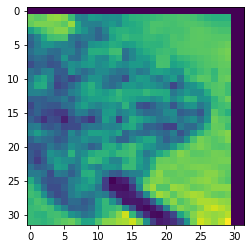

frog


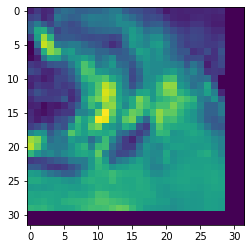

cat


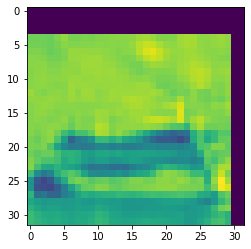

ship


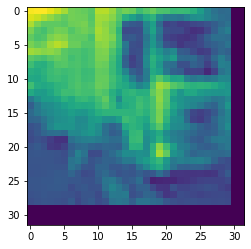

truck


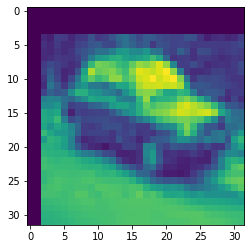

automobile


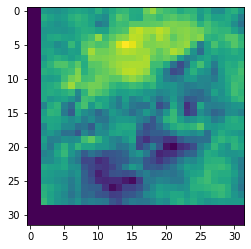

frog


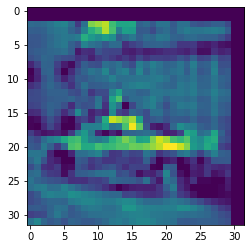

automobile


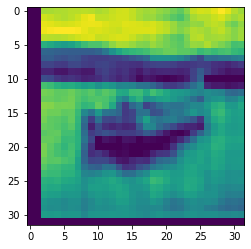

ship


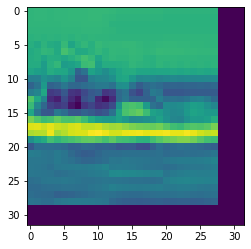

ship


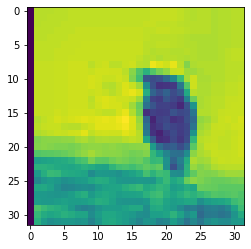

bird


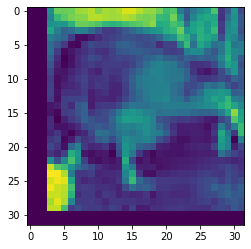

bird


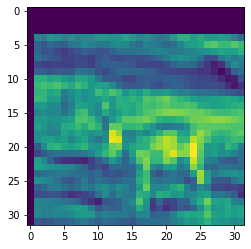

deer


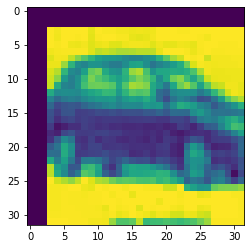

automobile


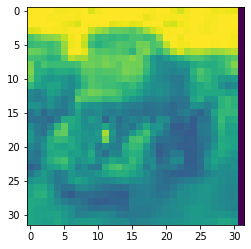

truck


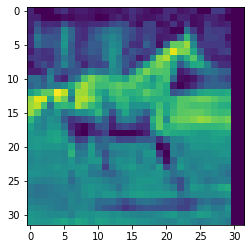

horse


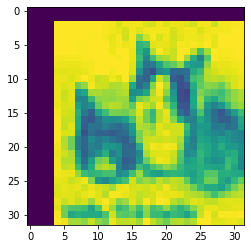

cat


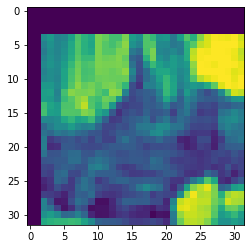

cat


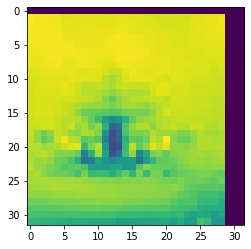

airplane


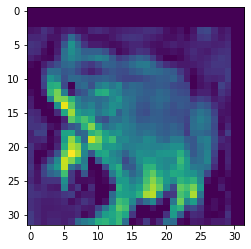

frog


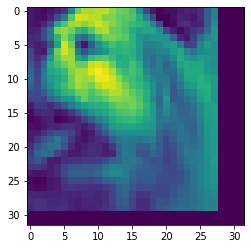

dog


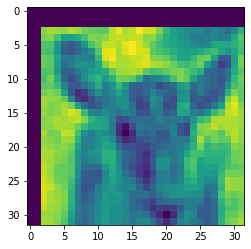

deer


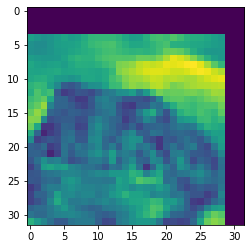

frog


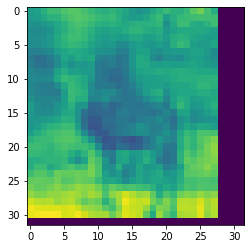

deer


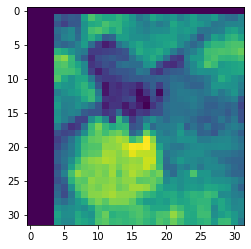

cat


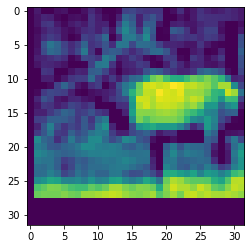

deer


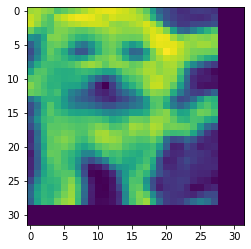

dog


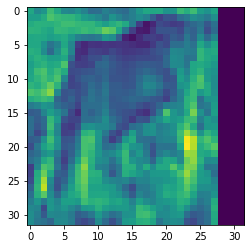

deer


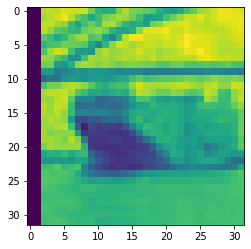

ship


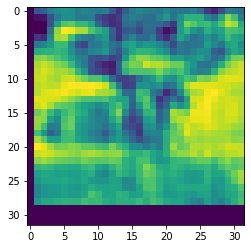

deer


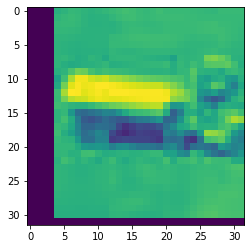

truck


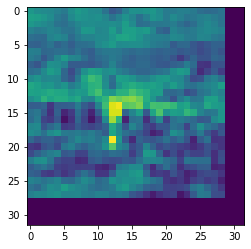

airplane


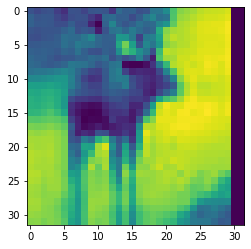

deer


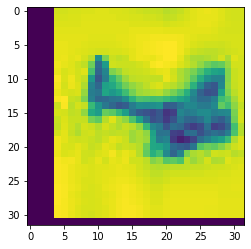

airplane


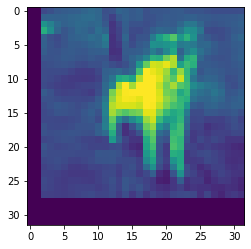

cat


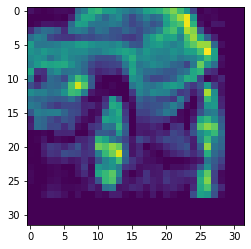

automobile


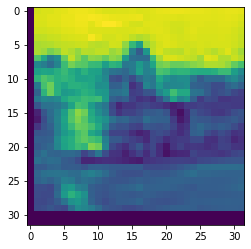

truck


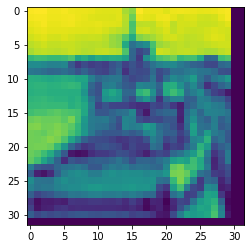

ship


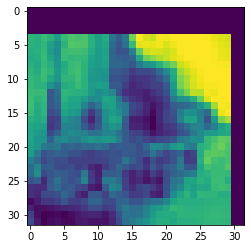

truck


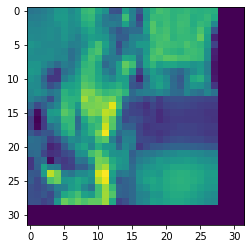

cat


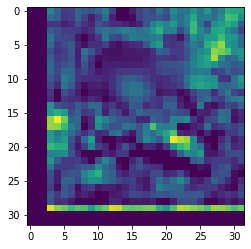

frog


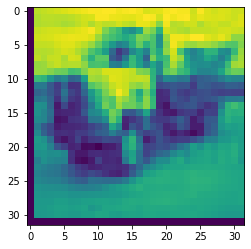

truck


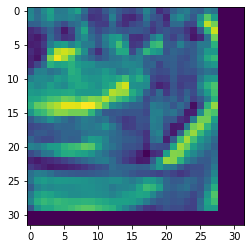

automobile


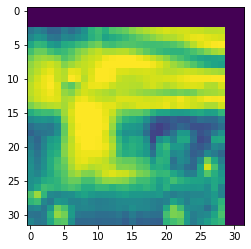

automobile


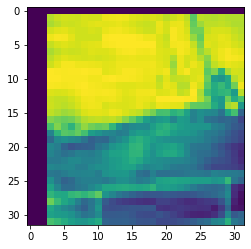

ship


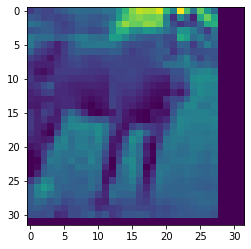

horse


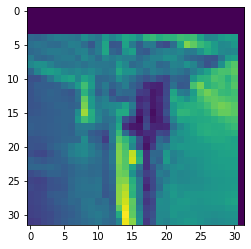

airplane


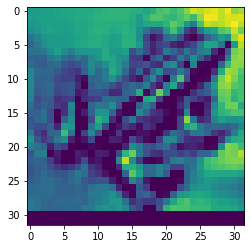

frog


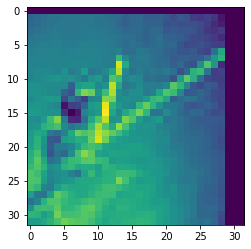

bird


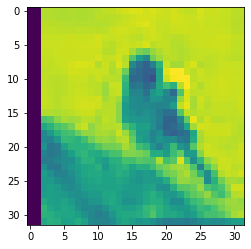

bird


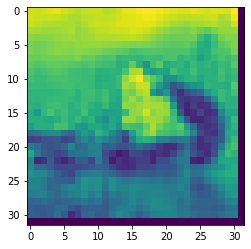

bird


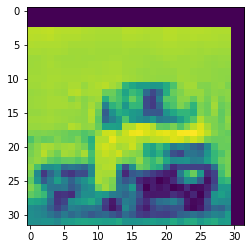

truck


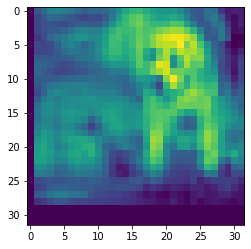

dog


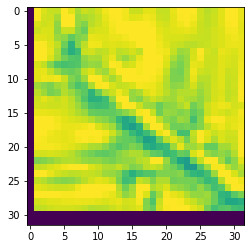

airplane


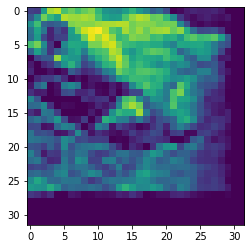

frog


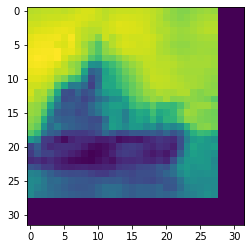

ship


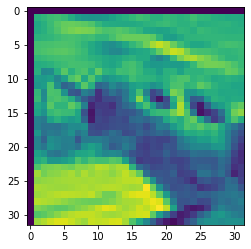

airplane


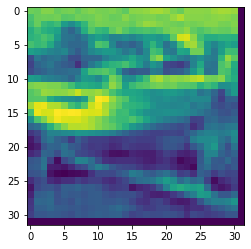

ship


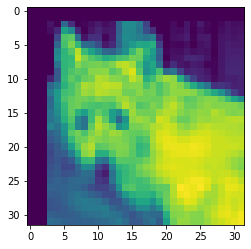

dog


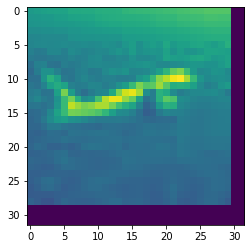

airplane


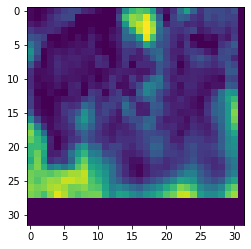

cat


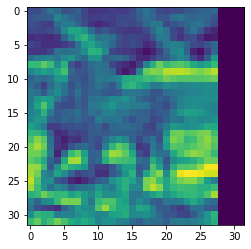

deer


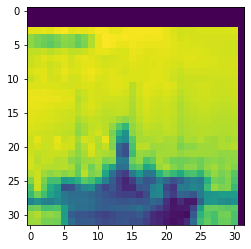

ship


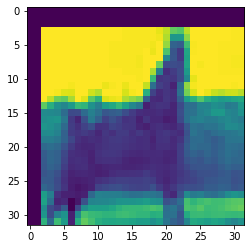

horse


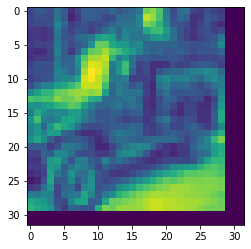

truck


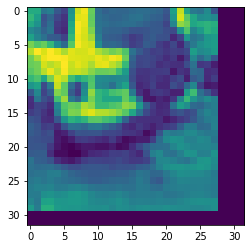

automobile


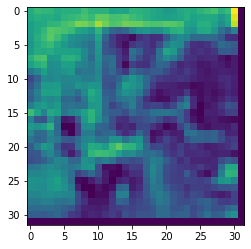

truck


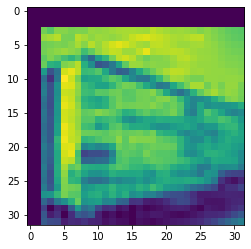

truck


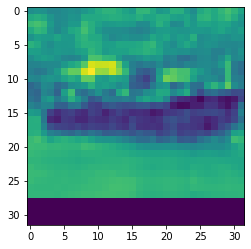

ship


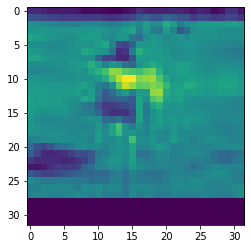

deer


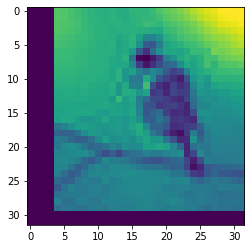

bird


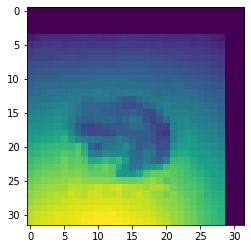

frog


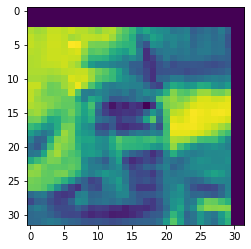

truck


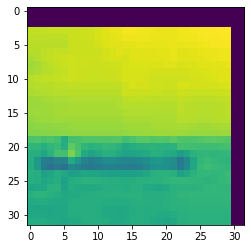

ship


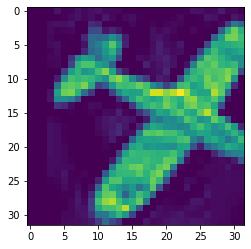

airplane


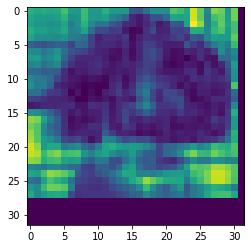

cat


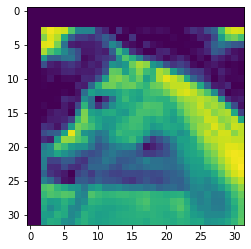

horse


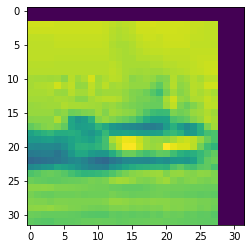

ship


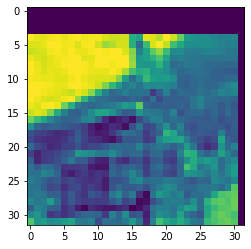

truck


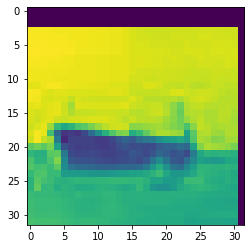

ship


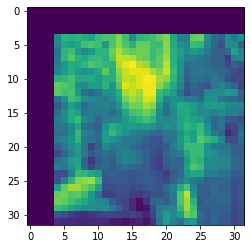

cat


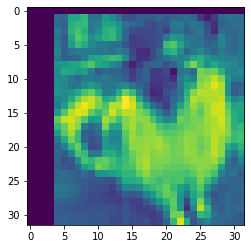

dog


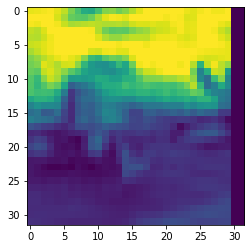

airplane


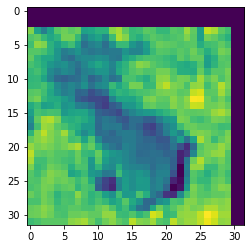

frog


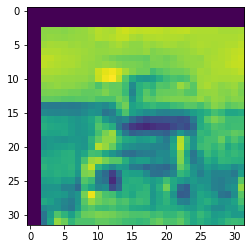

ship


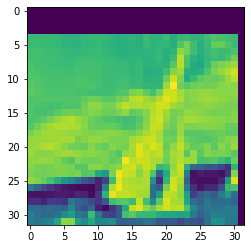

ship


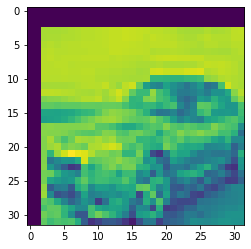

automobile


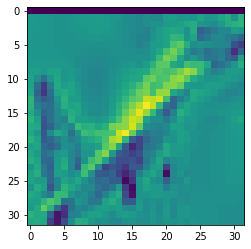

airplane


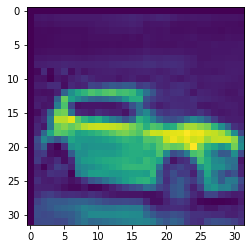

automobile


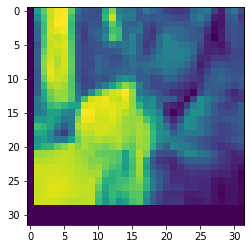

cat


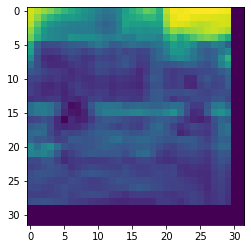

truck


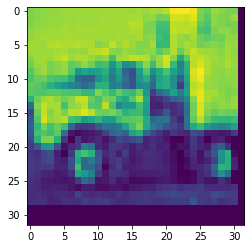

truck


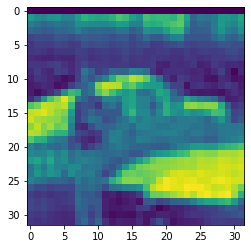

airplane


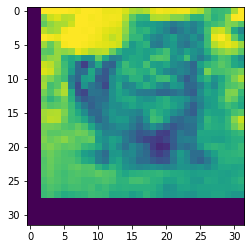

cat


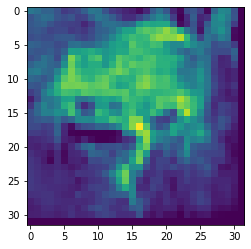

frog


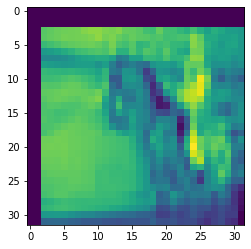

horse


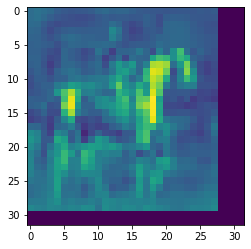

horse


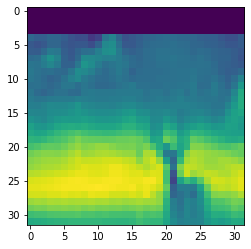

deer


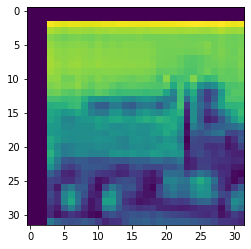

truck


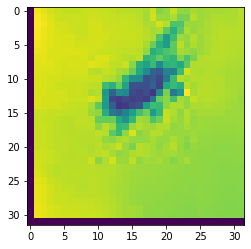

airplane


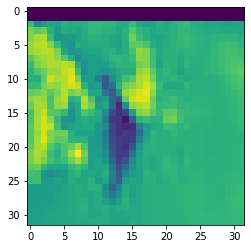

airplane


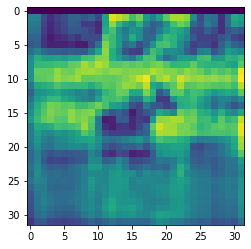

deer


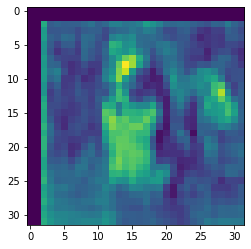

dog


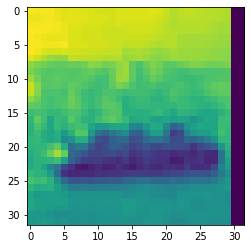

ship


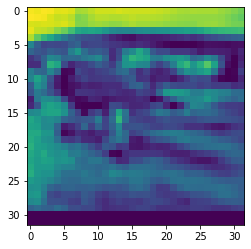

airplane


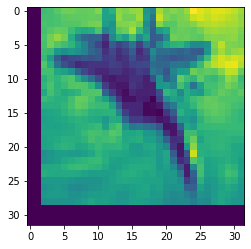

airplane


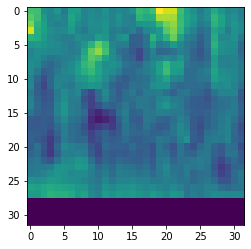

deer


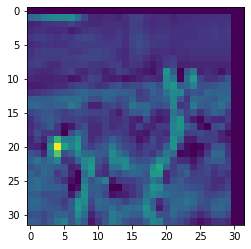

deer


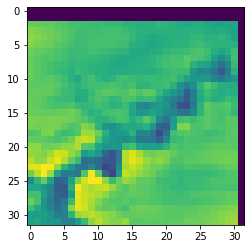

airplane


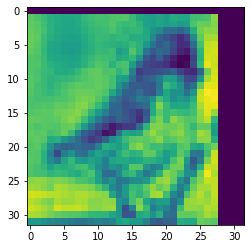

bird


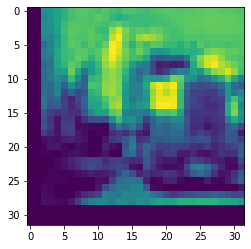

truck


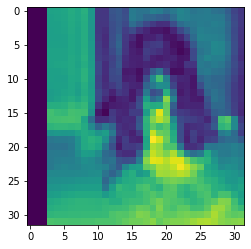

dog


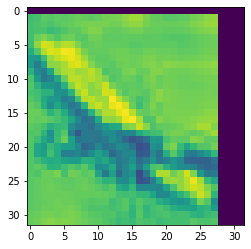

airplane


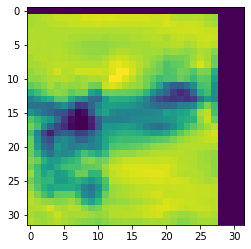

airplane


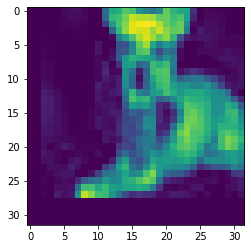

dog


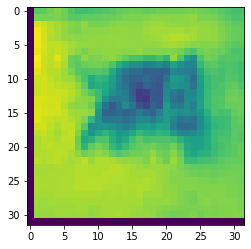

cat


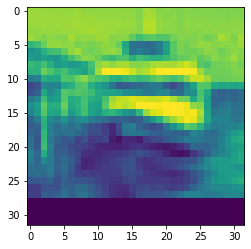

ship


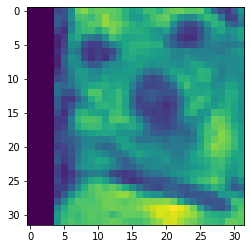

dog


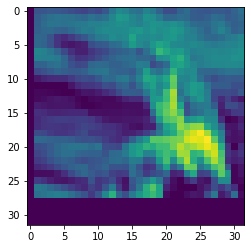

bird


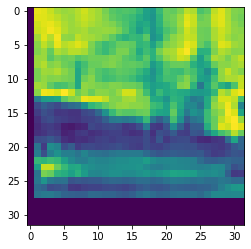

ship


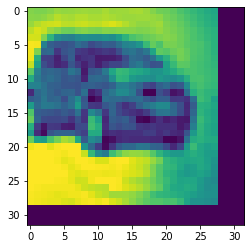

automobile


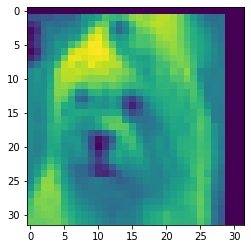

dog


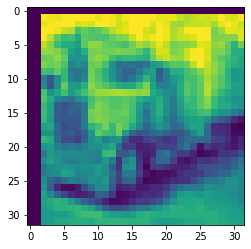

truck


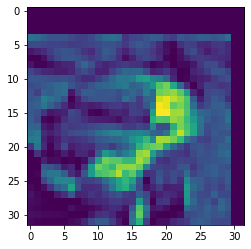

automobile


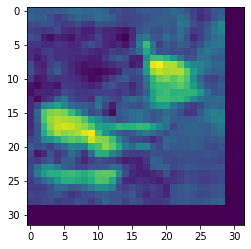

dog


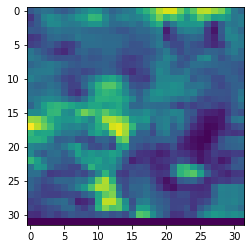

horse


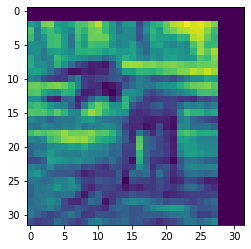

horse


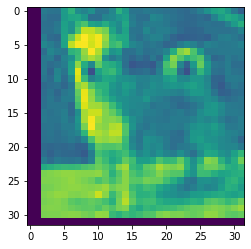

dog


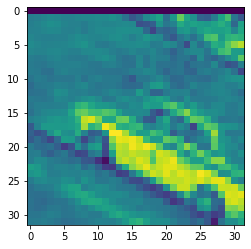

automobile


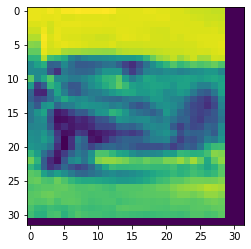

airplane


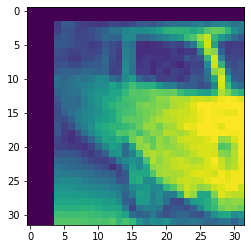

automobile


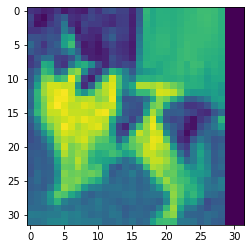

dog


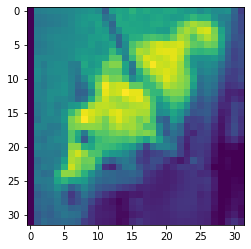

dog


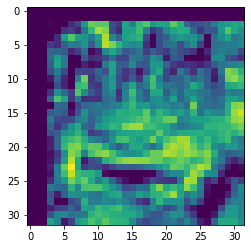

frog


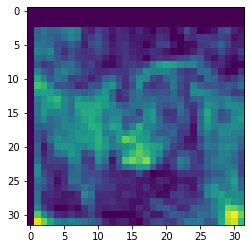

dog


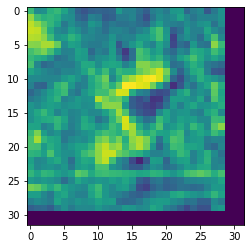

frog


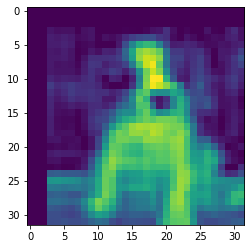

dog


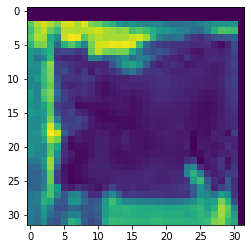

cat


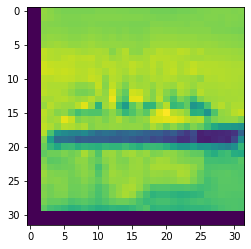

ship


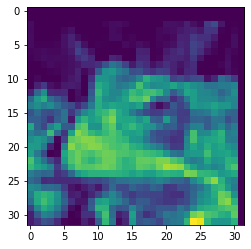

frog


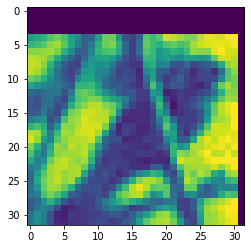

bird


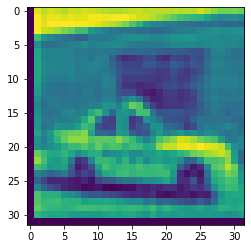

automobile


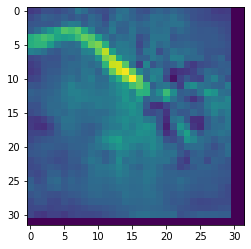

deer


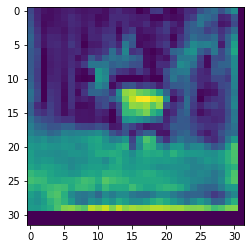

deer


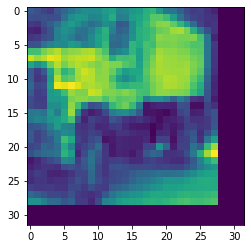

truck


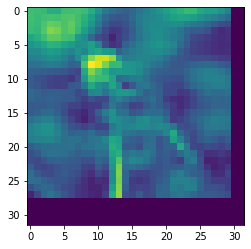

bird


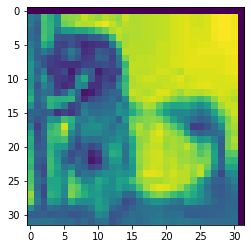

dog


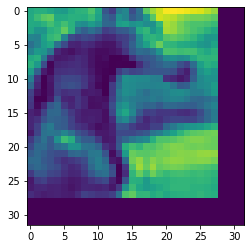

horse


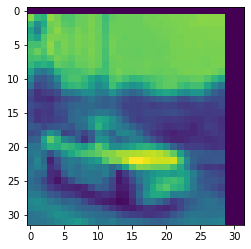

automobile


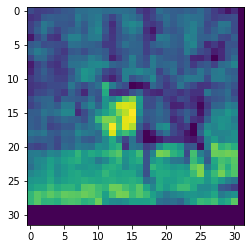

deer


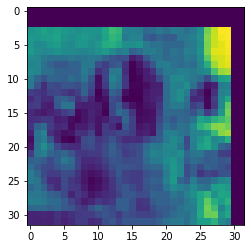

dog


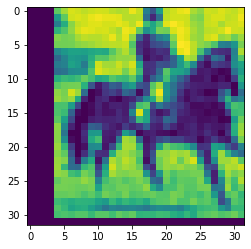

horse


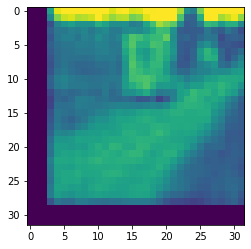

truck


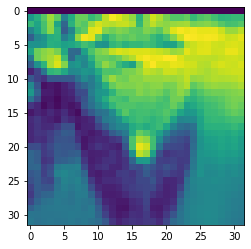

ship


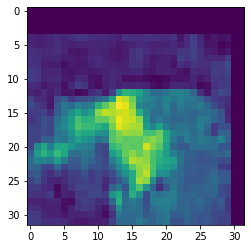

cat


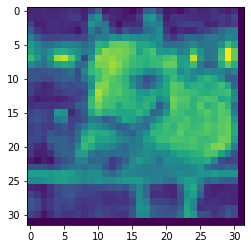

horse


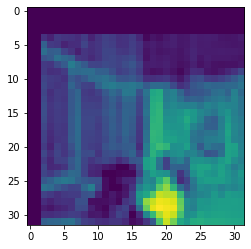

cat


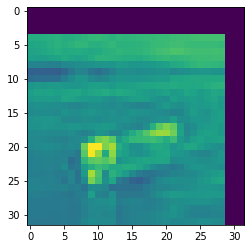

ship


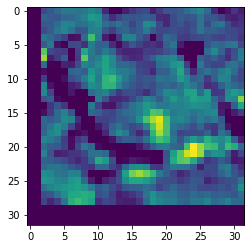

frog


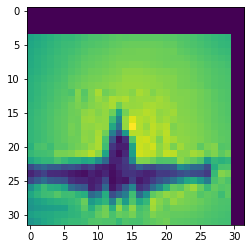

airplane


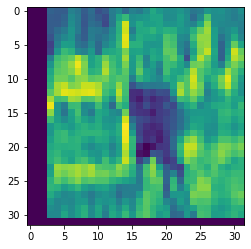

deer


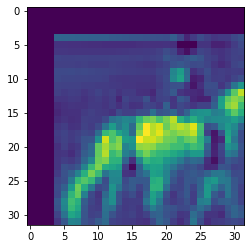

horse


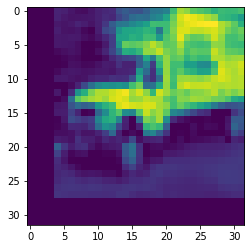

truck


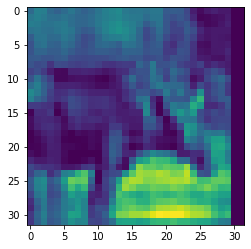

deer


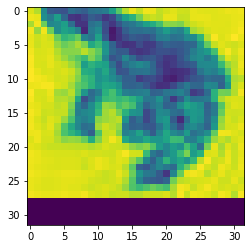

frog


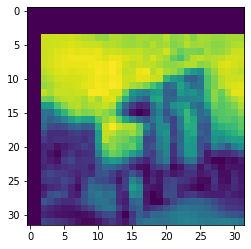

truck


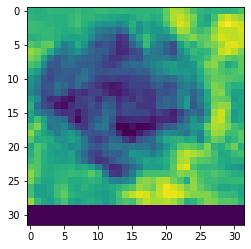

frog


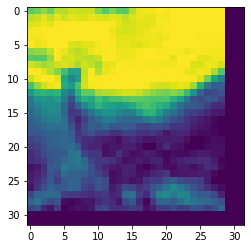

deer


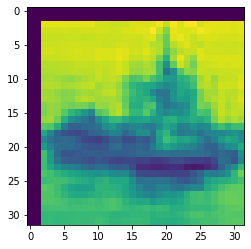

ship


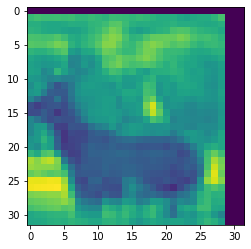

deer


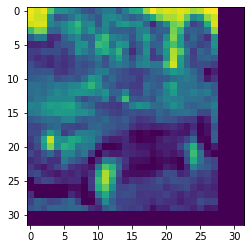

automobile


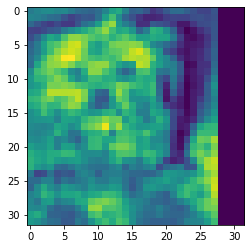

dog


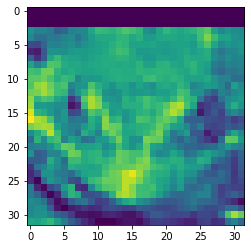

frog


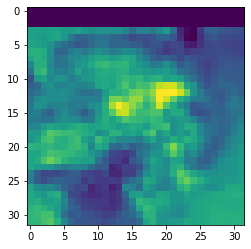

cat


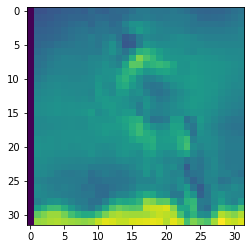

bird


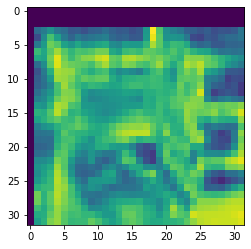

cat


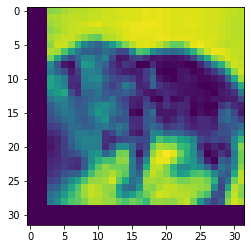

cat


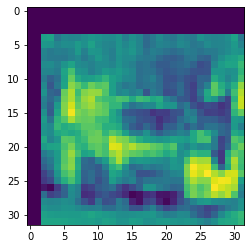

truck


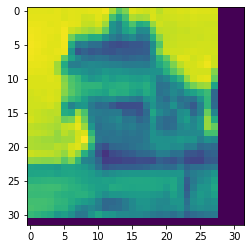

ship


KeyboardInterrupt: ignored

In [29]:
for i in trainloader:
  img=i['image'][10][0]
  cls=i['class'][10]
  plt.imshow(img)
  plt.show()
  print(cls)

In [ ]:
trainloader

In [30]:
import torch.nn as nn
import torch.nn.functional as F

# define the CNN architecture
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64 * 4 * 4, 500)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(500, 10)
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1, 64 * 4 * 4)
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x



In [31]:
class_dict = {'bird':0,
 'cat':1,
 'dog':2,
 'automobile':3,
 'horse':4,
 'frog':5,
 'ship':6,
 'deer':7,
 'airplane':8,
 'truck':9}

In [32]:
for i, sample in enumerate(trainloader):
  print(sample['class'])
  data_y = []
  for cls in sample['class']:
    data_y.append(class_dict[cls])
  print(data_y)

  break

['frog', 'deer', 'horse', 'cat', 'automobile', 'automobile', 'cat', 'deer', 'dog', 'ship', 'ship', 'automobile', 'truck', 'airplane', 'cat', 'truck', 'ship', 'deer', 'frog', 'deer']
[5, 7, 4, 1, 3, 3, 1, 7, 2, 6, 6, 3, 9, 8, 1, 9, 6, 7, 5, 7]


In [33]:
# number of epochs to train the model
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
model = Net().to(device)
n_epochs = 100

optimizer = optim.SGD(model.parameters(), lr = 0.001)
criterion = nn.CrossEntropyLoss()



valid_loss_min = np.Inf # track change in validation loss
for epoch in range(1, n_epochs+1):
    print("Train Epoch: ", epoch)

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    model.train()
    for sample in trainloader:
        batch_x = sample['image'].to(device)
        # batch_y =np.zeros((128,10)).astype('int')
        batch_y = []
        for i, cls in enumerate(sample['class']):
          # batch_y[i][class_dict[cls]] = 1 
          batch_y.append(class_dict[cls])
        batch_y = torch.tensor(batch_y).to(device)
        # print(batch_y.tolist())

        output = model(batch_x)
        # move tensors to GPU if CUDA is available
        # if train_on_gpu:
        #     data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        # output = model(data)
        # calculate the batch loss
        #print(batch_y[0])
        #print(output[0])
        loss = criterion(output, batch_y)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()
        
    ######################    
    # validate the model #
    ######################
    # model.eval()
    for sample in validloader:
        batch_x = sample['image'].to(device)
        batch_y = []
        for cls in sample['class']:
          batch_y.append(class_dict[cls])
        batch_y = torch.tensor(batch_y).to(device)


        # forward pass: compute predicted outputs by passing inputs to the model
        output = model(batch_x)
        # calculate the batch loss
        
        loss = criterion(output, batch_y)
        # update average validation loss 
        valid_loss += loss.item()
    
    # calculate average losses
    #train_loss = train_loss/len(trainloader.sampler)
    # valid_loss = valid_loss/len(valid_loader.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    #save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(model.state_dict(), 'model_cifar.pt')
        valid_loss_min = valid_loss

Train Epoch:  1
Epoch: 1 	Training Loss: 4588.880083 	Validation Loss: 1140.475418
Validation loss decreased (inf --> 1140.475418).  Saving model ...
Train Epoch:  2
Epoch: 2 	Training Loss: 4497.801526 	Validation Loss: 1101.244842
Validation loss decreased (1140.475418 --> 1101.244842).  Saving model ...
Train Epoch:  3
Epoch: 3 	Training Loss: 4264.398794 	Validation Loss: 1029.568786
Validation loss decreased (1101.244842 --> 1029.568786).  Saving model ...
Train Epoch:  4
Epoch: 4 	Training Loss: 4028.049777 	Validation Loss: 994.687661
Validation loss decreased (1029.568786 --> 994.687661).  Saving model ...
Train Epoch:  5
Epoch: 5 	Training Loss: 3900.134237 	Validation Loss: 967.047751
Validation loss decreased (994.687661 --> 967.047751).  Saving model ...
Train Epoch:  6
Epoch: 6 	Training Loss: 3801.756744 	Validation Loss: 945.443996
Validation loss decreased (967.047751 --> 945.443996).  Saving model ...
Train Epoch:  7
Epoch: 7 	Training Loss: 3710.535567 	Validation Los

In [34]:
# track test loss
test_loss = 0.0
# class_correct = list(0. for i in range(10))
# class_total = list(0. for i in range(10))
actual=[]
predict=[]





#device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')

# model = Net().to(device)
# optimizer = optim.SGD(model.parameters(), lr = 0.001)
# criterion = nn.CrossEntropyLoss()

model.eval()
# iterate over test data
for sample in testloader:
  batch_x = sample['image'].to(device)
  batch_y = []
  for cls in sample['class']:
    batch_y.append(class_dict[cls])
  batch_y = torch.tensor(batch_y).to(device)
  #print(batch_y.tolist())
  output = model(batch_x)
  #print(batch_x)
    # calculate the batch loss
  loss = criterion(output, batch_y)
    # update test loss 
  test_loss += loss.item()
    # convert output probabilities to predicted class
  _, pred = torch.max(output, 1)    
    # compare predictions to true label
  correct_tensor = pred.eq(batch_y.data.view_as(pred))
  #print(correct_tensor)
  correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
  for i in correct:
    predict.append(i)
  for j in  batch_y.tolist():
    actual.append(j)
  # print(predict)
  # print(actual)

    # calculate test accuracy for each object class
#   for i in range(len(correct)):
#       label = batch_y.data[i]
#       class_correct[label] += correct[i].item()
#       class_total[label] += 1

# # average test loss
# test_loss = test_loss/len(testloader.dataset)
# print('Test Loss: {:.6f}\n'.format(test_loss))


# for i in range(10):
#     if class_total[i] > 0:
#         print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
#             classes[i], 100 * class_correct[i] / class_total[i],
#             np.sum(class_correct[i]), np.sum(class_total[i])))
#     else:
#         print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

# print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
#     100. * np.sum(class_correct) / np.sum(class_total),
#     np.sum(class_correct), np.sum(class_total)))

In [35]:
(sum(predict)/len(predict))*100

71.88